In [63]:
import logging
import numpy as np
import astropy.units as u
from astropy.coordinates.angle_utilities import angular_separation
from astropy.utils import lazyproperty
from regions import CircleSkyRegion, PointSkyRegion
import matplotlib.pyplot as plt
from gammapy.maps import HpxNDMap, Map, RegionNDMap, WcsNDMap, MapAxis, WcsGeom, RegionGeom
from gammapy.modeling.models import PointSpatialModel, TemplateNPredModel
# import warnings
# warnings.simplefilter("error")

PSF_CONTAINMENT = 0.999
CUTOUT_MARGIN = 0.1 * u.deg

log = logging.getLogger(__name__)

In [64]:
import os
os.chdir('../EventDataset/')
from utils import *
from UnbinnedEvaluator import UnbinnedEvaluator

In [3]:
%load_ext autoreload
%autoreload 2

## Idea

The Evaluator is initiated with only the model. At the first call the `update` method is called with the events, IRFs, mask, pointing, etc...  
The IRFs and events do not need to be stored because only the model, the integration geom and the mask are necessay together with the calculated IRF cube and acceptance cube.

We copy from the `MapEvaluator` and adapt its functionalities.

In [99]:
class UnbinnedEvaluator:
    """Sky model evaluation at events' coordinates.
    Evaluates a sky model's differential flux at the events's coordinates 
    and returns an array with an entry for each contributing event.
    Convolution with IRFs is done by interpolating the PDFs at each event's coordinates
    and multiplying this with the integrated model prediction.
    Parameters
    ----------
    model : `~gammapy.modeling.models.SkyModel`
        Sky model
    events : `~gammapy.data.EventList`
            EventList with the events inside the mask
    mask : `~gammapy.maps.Map`
        Mask to apply to the likelihood for fitting.
    exposure : `~gammapy.maps.Map` 
        Exposure map
    gti : `~gammapy.data.GTI`
        GTI of the observation or union of GTI if it is a stacked observation
    evaluation_mode : {"local", "global"}
        Model evaluation mode.
        The "local" mode evaluates the model components on smaller grids to save computation time.
        This mode is recommended for local optimization algorithms.
        The "global" evaluation mode evaluates the model components on the full map.
        This mode is recommended for global optimization algorithms.
    use_cache : bool
        Use caching of the previous response. 
    energy_axis : `~gammapy.maps.MapAxis`
        True energy axis for the model integration. If None the energy axis of the exposure is used.
    spatialbs : `~astropy.units.quantity.Quantity`
        The spatial binsize for the model evaluation. If None the binsize of the exposure will be up-/downsampled
        according to the model's `evaluation_bin_size_min`.
    """

    def __init__(
        self,
        model,
        events=None,
        mask = None,
        exposure= None,
        gti = None,
        evaluation_mode="local",
        use_cache=True,
        energy_axis=None,
        spatialbs=None
    ):

        self.model = model
        self.events = events
        self.mask = mask
        self.exposure= exposure
        self.gti = gti  # TODO: Check if we really need this
        self.use_cache = use_cache
        self._init_position = None
        self.contributes = True
        self.psf_containment = None
        self.energy_axis = energy_axis
        self.spatialbs = spatialbs
        self.geom = None
        self.irf_cube = None
        self._psf_width = 0.0 * u.deg
        
        if evaluation_mode not in {"local", "global"}:
            raise ValueError(f"Invalid evaluation_mode: {evaluation_mode!r}")

        self.evaluation_mode = evaluation_mode

        # TODO: this is preliminary solution until we have further unified the model handling
        if (
            isinstance(self.model, TemplateNPredModel)
            or self.model.spatial_model is None
            or self.model.evaluation_radius is None
        ):
            self.evaluation_mode = "global"

        # define cached computations
        self._cached_parameter_values = None
        self._cached_parameter_values_previous = None
        self._cached_parameter_values_spatial = None
        self._cached_position = (0, 0)
        self._computation_cache = None
        self._neval = 0  # for debugging
        self._renorm = 1
        self._spatial_oversampling_factor = 1
        self.irf_unit = u.Unit('')
        if self.exposure is not None:
            if not self.geom.is_region or self.geom.region is not None:
                self.update_spatial_oversampling_factor(self.geom)

    def reset_cache_properties(self):
        """Reset cached properties."""
        del self._compute_npred

    # just use the exposure geometry because of edisp problems otherwise.
    def _init_geom(self, exposure):
        """True energy map geometry (`~gammapy.maps.Geom`) on which the model will be integrated"""
        
        geom = exposure.geom
        
        # cutout if neccessary
        if self.evaluation_mode == "local":
            self.contributes = self.model.contributes(mask=self.mask, margin=self.psf_width)
            if self.contributes:
                radius = self.model.evaluation_radius
                if radius is not None:
                    geom=geom.cutout(self.model.position, (radius+CUTOUT_MARGIN)*2)
        
        # adjust the spatial binsize if neccessary
        res_scale = self.spatialbs or self.model.evaluation_bin_size_min
#         res_scale = self.spatialbs if self.spatialbs is not None else self.model.evaluation_bin_size_min # avoids AstropyDeprecationWarning
        if res_scale is not None:
            pixel_size=np.max(geom.pixel_scales)
            if pixel_size > res_scale:
                geom = geom.upsample(int(np.ceil(pixel_size/res_scale)))
            elif pixel_size < res_scale/2:
                geom = geom.downsample(int(np.floor(res_scale/pixel_size)))
        
        # adjust the energy axis if given
        if self.energy_axis is not None:
            geom = geom.to_image().to_cube([self.energy_axis])
        self.geom = geom

    @property
    def needs_update(self):
        """Check whether the model component has drifted away from its support."""
        # TODO: simplify and clean up
        if isinstance(self.model, TemplateNPredModel):
            return False
        elif not self.contributes:
            return False
        elif self.exposure is None:
            return True
        elif self.geom.is_region:
            return False
        elif self.evaluation_mode == "global" or self.model.evaluation_radius is None:
            return False
        elif not self.parameters_spatial_changed(reset=False):
            return False
        else:
            return self.irf_position_changed

    @property
    def psf_width(self):
        """Width of the PSF"""
        return self._psf_width

    def use_psf_containment(self, geom):
        """Use psf containment for point sources and circular regions"""
        if not geom.is_region:
            return False

        is_point_model = isinstance(self.model.spatial_model, PointSpatialModel)
        is_circle_region = isinstance(geom.region, CircleSkyRegion)
        return is_point_model & is_circle_region

    @property
    def cutout_width(self):
        """Cutout width for the model component"""
        return self.psf_width + 2 * (self.model.evaluation_radius + CUTOUT_MARGIN)

    def update(self, events, exposure, psf=None, edisp=None, mask=None, use_modelpos=False):
        """Update the integration geometry, the kernel cube and the acceptance cube of the EventEvaluator, 
        based on the current position of the model component.
        Parameters
        ----------
        exposure : `~gammapy.maps.Map`
            Exposure map.
        psf : `gammapy.irf.PSFMap`
            PSF map.
        edisp : `gammapy.irf.EDispMap`
            Edisp map.
        geom : `WcsGeom`
            Counts geom
        mask : `~gammapy.maps.Map`
            Mask to apply to the likelihood for fitting.
        use_modelpos : bool
            Wether or not to evaluate the IRFs at the model position or at each skycoord of the integration geom 
        """
        # TODO: simplify and clean up
        log.debug("Updating model evaluator")
        self.events = events
        self.mask = mask
        self.irf_unit = u.Unit('')
        self._cached_position = self.model.position_lonlat
        if self.evaluation_mode == "local":
            self.contributes = self.model.contributes(mask=mask, margin=self.psf_width)
        if self.contributes:
            # 1. get the contributing events which are close enough to the model
            del self.event_mask
            coords = events.map_coord(mask.geom)
            events = events.select_row_subset(self.event_mask)
            
            if isinstance(self.model, TemplateNPredModel):
                # the TemplateNpredModel only needs to be interpolated at 
                # the events' coordinates. No IRF cube necessary.
                return
            
            # init the proper integration geometry
            self._init_geom(exposure)
            self.exposure = exposure.interp_to_geom(self.geom)
            ### rely on float32 precision
            self.exposure.data = self.exposure.data.astype(np.float32)
            if use_modelpos == True:
                position = self.model.position
            else: position=None
            # get the edisp kernel factors for each event
            if edisp is not None:
                edisp_factors = make_edisp_factors(edisp, self.geom, events, position=position)
                self.irf_unit /= u.TeV
            else:
                edisp_factors = 1.0

            # get the psf kernel factors for each event
            if psf is not None and self.model.spatial_model:
                # TODO: Set a width according to a containment
                self._psf_width = psf.psf_map.geom.axes['rad'].edges.max() 
                psf_factors = make_psf_factors(psf, self.geom, events, position=position)
                self.irf_unit /= u.sr
            else:
                psf_factors = 1.0

            if len(self.geom.data_shape)+1 != len(edisp_factors.shape):
                if not isinstance(edisp_factors, float):
                    edisp_factors = np.expand_dims(edisp_factors, axis=(-1,-2))
            # maybe use sparse matrix
            self.irf_cube = psf_factors * edisp_factors
            ### rely on float32 precision
            self.irf_cube = self.irf_cube.astype(np.float32)
            
            if mask is not None:
                self.acceptance = make_acceptance(self.geom, mask, edisp, psf, self.model.position)
            else: self.acceptance = 1.0
            
        self.reset_cache_properties()
        self._computation_cache = None
        self._cached_parameter_previous = None
    
    @lazyproperty
    def event_mask(self):
        """create a mask for events too far away from the model"""
        # the spatial part: separation from the model center
        separation = self.events.radec.separation(self.model.position)
        # TODO: Define an individual width for each event dependent on its energy
        mask_spatial = separation < self.cutout_width/2 
        
        # possibility for an energy or temporal mask
        
        return mask_spatial

    

    @lazyproperty
    def _compute_npred(self):
        """Compute npred"""
        if isinstance(self.model, TemplateNPredModel):
            npred = self.model.evaluate()
            # interpolate on the events
            coords = self.events.map_coord(self.mask.geom)
            response = npred.interp_by_coord(coords)
            total = np.sum(npred.data[self.mask.data])
            
        else:
            if not self.parameter_norm_only_changed:
                npred=self.model.integrate_geom(self.geom, self.gti) 
                ### rely on float32 precision
                npred.data = npred.data.astype(np.float32)
                npred *= self.exposure.quantity
                response = self.irf_cube * npred
                total = npred * self.acceptance.data
                axis_idx = np.arange(len(response.shape)) # the indices to sum over
                axis_idx=np.delete(axis_idx, 0) # dim 0 needs to be the event axis
                response = response.to_value(self.irf_unit).sum(axis=tuple(axis_idx))
                total = total.quantity.to_value('').sum() 
                self._computation_cache = response, total
            else:
                response, total = self._computation_cache
                response *= self.renorm()
                total *= self.renorm()
                self._computation_cache = response, total
        return response, total

    @property
    def apply_psf_after_edisp(self):
        return (
            self.psf is not None and "energy" in self.psf.psf_kernel_map.geom.axes.names
        )

    def compute_npred(self):
        """Evaluate model predicted counts.
        Returns
        -------
        npred : `~gammapy.maps.Map`
            Predicted counts on the map (in reco energy bins)
        """
        if self.parameters_changed or not self.use_cache:
            del self._compute_npred

        return self._compute_npred

    @property
    def parameters_changed(self):
        """Parameters changed"""
        values = self.model.parameters.value

        # TODO: possibly allow for a tolerance here?
        changed = ~np.all(self._cached_parameter_values == values)

        if changed:
            self._cached_parameter_values = values

        return changed

    @property
    def parameter_norm_only_changed(self):
        """Only norm parameter changed"""
        norm_only_changed = False
        idx = self._norm_idx
        values = self.model.parameters.value
        if idx and self._computation_cache is not None:
            changed = self._cached_parameter_values_previous == values
            norm_only_changed = sum(changed) == 1 and changed[idx]

        if not norm_only_changed:
            self._cached_parameter_values_previous = values
        return norm_only_changed

    def parameters_spatial_changed(self, reset=True):
        """Parameters changed
        Parameters
        ----------
        reset : bool
            Reset cached values
        Returns
        -------
        changed : bool
            Whether spatial parameters changed.
        """
        values = self.model.spatial_model.parameters.value

        # TODO: possibly allow for a tolerance here?
        changed = ~np.all(self._cached_parameter_values_spatial == values)

        if changed and reset:
            self._cached_parameter_values_spatial = values

        return changed

    @property
    def irf_position_changed(self):
        """Position for IRF changed"""

        # Here we do not use SkyCoord.separation to improve performance
        # (it avoids equivalence comparisons for frame and units)
        lon_cached, lat_cached = self._cached_position
        lon, lat = self.model.position_lonlat

        separation = angular_separation(lon, lat, lon_cached, lat_cached)
        changed = separation > CUTOUT_MARGIN.to_value(u.rad)

        if changed:
            self._cached_position = lon, lat

        return changed

    @lazyproperty
    def _norm_idx(self):
        """norm index"""
        names = self.model.parameters.names
        ind = [idx for idx, name in enumerate(names) if name in ["norm", "amplitude"]]
        if len(ind) == 1:
            return ind[0]
        else:
            return None

    def renorm(self):
        value = self.model.parameters.value[self._norm_idx]
        if self._cached_parameter_values_previous is None:
            return 1.0
        else:
            value_cached = self._cached_parameter_values_previous[self._norm_idx]
            return value / value_cached

In [4]:
from gammapy.data import DataStore, Observation
from gammapy.datasets import MapDataset, MapDatasetEventSampler, Datasets
from gammapy.makers import MapDatasetMaker, FoVBackgroundMaker, SafeMaskMaker
from astropy.coordinates import SkyCoord
from gammapy.modeling.models import (
#     Model,
#     Models,
    SkyModel,
#     PowerLawSpectralModel,
#     PowerLawNormSpectralModel,
#     PointSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
#     TemplateSpatialModel,
#     ExpDecayTemporalModel,
#     LightCurveTemplateTemporalModel,
    FoVBackgroundModel,
)

In [5]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

In [6]:
obs_id = [23523] # just one observation 
obs1 = data_store.get_observations(obs_id)[0]
# selection = dict(
#     type="sky_circle",
#     frame="icrs",
#     lon="83.633 deg",
#     lat="22.014 deg",
#     radius="5 deg",
# )
# selected_obs_table = data_store.obs_table.select_observations(selection)

In [7]:
print(obs1.events)

EventList
---------

  Instrument       : H.E.S.S. Phase I
  Telescope        : HESS
  Obs. ID          : 23523

  Number of events : 7613
  Event rate       : 4.513 1 / s

  Time start       : 53343.92234009259
  Time stop        : 53343.94186555556

  Min. energy      : 2.44e-01 TeV
  Max. energy      : 1.01e+02 TeV
  Median energy    : 9.53e-01 TeV

  Max. offset      : 58.0 deg



In [11]:
crab_pos = SkyCoord(184.557, -5.784, unit='deg', frame='galactic') 
obs_pos = obs1.pointing_radec
# choose energy binning
ebins = np.logspace(-1,2,49)
ebins_true = np.logspace(-1,2,49)

energy_axis = MapAxis.from_edges(
    ebins, unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins_true, unit="TeV", name="energy_true", interp="log"  
)
migra_axis = MapAxis.from_bounds(
    0.2, 5, nbin=160, node_type="edges", name="migra"
)
geom = WcsGeom.create(
    skydir=crab_pos,
    binsz=0.02,
    width=(3.5, 3.5),
    frame="icrs",  # same frame as events
    proj="CAR",
    axes=[energy_axis],
)

circle = CircleSkyRegion(
    center=crab_pos, radius=0.3 * u.deg
)
data = geom.region_mask(regions=[circle], inside=False)
exclusion_mask = ~geom.region_mask(regions=[circle])
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

In [17]:
rgeom=RegionGeom(PointSkyRegion(crab_pos), axes=[energy_axis_true])

In [18]:
maker = MapDatasetMaker(background_oversampling=2)
maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max='1.5 deg')
# providing the migra axis seems essential so that edisp is a EdispMap and no EdispKernelMap
reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis)  

dataset = maker.run(reference, obs1)
dataset = maker_safe_mask.run(dataset, obs1)
dataset.mask_safe *= geom.energy_mask(energy_min=1*u.TeV)
# assert np.isfinite(dataset.background.data[dataset.mask_safe.data]).all()
# dataset.background.data[~dataset.mask_safe.data] = 0.0

bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
dataset.models=bkg_model
# dataset.background_model.spectral_model.tilt.frozen = False
# dataset = maker_fov.run(dataset)
# print(
#     f"Background norm obs {obs1.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f} \
#     (tilt={dataset.background_model.spectral_model.tilt.value:.2f})"
# )

In [19]:
model_gauss = SkyModel(
#     spatial_model=GaussianSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", sigma='0.016 deg', frame = 'galactic'),
    spatial_model=PointSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", frame = 'galactic'),
    spectral_model=LogParabolaSpectralModel(amplitude='3.5e-11 cm-2 s-1 TeV-1', 
                                          reference='1 TeV', 
                                          alpha=1.8, 
                                          beta=0.4
                                         ),
    name='crab_model_gauss'
    )
dataset.models += model_gauss

In [20]:
model_gauss2=model_gauss.copy()
model_gauss2.spatial_model.parameters.freeze_all()

In [111]:
# Set up a test instance of the unbinned Evaluator
test=UnbinnedEvaluator(model_gauss,events=obs1.events, mask=dataset.mask_safe, spatialbs=0.02*u.deg, use_cache=False)
test2=UnbinnedEvaluator(model_gauss2,events=obs1.events, mask=dataset.mask_safe, spatialbs=0.02*u.deg, use_cache=False)
# test.mask = dataset.mask_safe

# test._init_geom(exposure=dataset.exposure)
### for a proper comparison set the default value for the psf oversampling
### factor in 'update' to 1
test.update(obs1.events,dataset.exposure,dataset.psf,dataset.edisp, dataset.mask_safe)
test2.update(obs1.events,dataset.exposure,dataset.psf,dataset.edisp, dataset.mask_safe)

In [22]:
region=test2.geom.region

exp1 = test.exposure.get_spectrum(region)
exp2 = test2.exposure

/home/hpc/caph/mppi086h/wecap/software/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/astropy/units/quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0, 0.5, 'ratio')

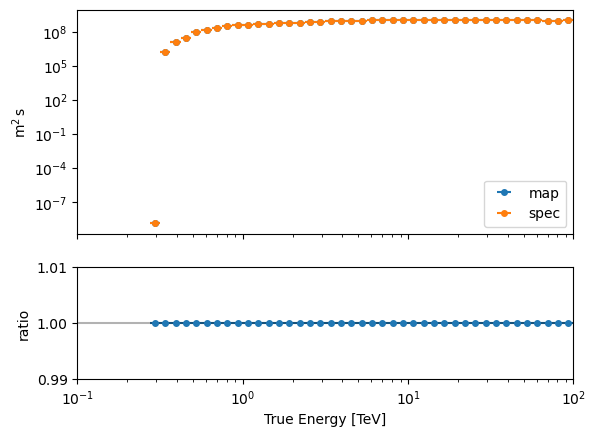

In [23]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, height_ratios=(2,1))
exp1.plot(ax=ax1, label='map')
exp2.plot(ax=ax1, label='spec')
ax1.legend()
ax1.set_xlabel(None)

ratio = exp2/exp1
ratio.plot(ax=ax2)
ax2.set_yscale('linear')
ax2.set_ylim(0.99, 1.01)
ax2.axhline(1, c='k', alpha=0.3)
ax2.set_ylabel('ratio')
# print(ratio.data)

In [24]:
id1=0
id2=0
idx_match={}  # dict with event_idx2: event_idx1
for i in range(len(test.event_mask)):
    if test.event_mask[i] & test2.event_mask[i]:
        idx_match[id2] = id1
    if test.event_mask[i] == True:
        id1 += 1
    if test2.event_mask[i] == True:
        id2 += 1
        
idx_both=np.where(test.event_mask & test2.event_mask)[0]

(0.99, 1.01)

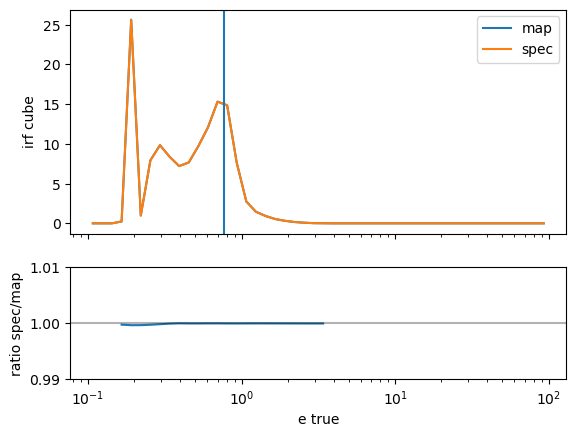

In [113]:
id2=7
id1=idx_match[id2]
ic1 = test.irf_cube[id1,:,5,5]  # The pixel 5,5 has most of the model counts
ic2 = test2.irf_cube[id2,:,0,0]
e_true = test.geom.axes[0].center

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, height_ratios=(2,1))
ax1.semilogx(e_true, ic1, label='map')
ax1.semilogx(e_true, ic2, label='spec')
ax1.legend()
ax1.set_ylabel('irf cube')

ax1.axvline(test.events.energy[test.event_mask][id1].to_value(e_true.unit))

ax2.plot(e_true, ic2/ic1)
ax2.set_ylabel('ratio spec/map')
ax2.set_xlabel('e true')
ax2.axhline(1, c='k', alpha=0.3)
ax2.set_ylim(0.99,1.01)

Text(0, 0.5, 'ratio')

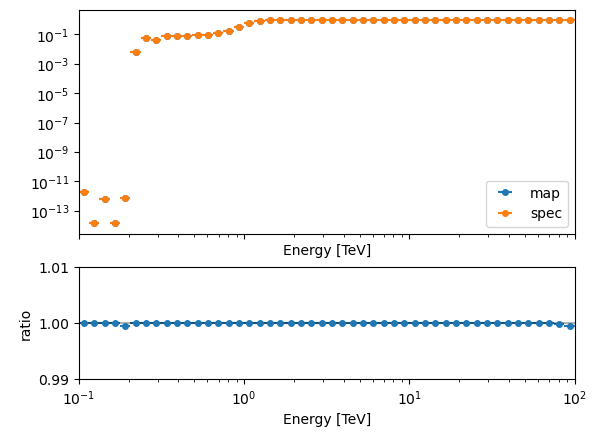

In [115]:
acc1 = test.acceptance.get_spectrum(region)
acc2 = acc1.copy()
acc2.data = test2.acceptance.value

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, height_ratios=(2,1))
acc1.plot(ax=ax1, label='map')
acc2.plot(ax=ax1, label='spec')
ax1.legend()

ratio_acc= acc2/acc1
ratio_acc.plot(ax=ax2)
ax2.set_yscale('linear')
ax2.set_ylim(0.99, 1.01)
ax2.axhline(1, c='k', alpha=0.3)
ax2.set_ylabel('ratio')

Text(0, 0.5, 'ratio')

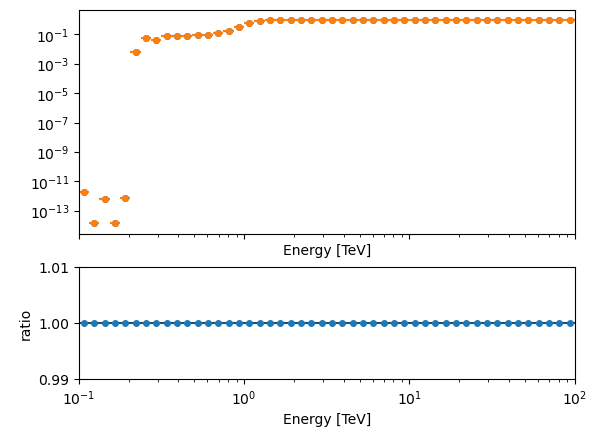

In [116]:
eacc1 = make_acceptance(test.geom, dataset.mask, dataset.edisp, dataset.psf, 
                        test.model.position, dtype=test.dtype, factor=1, debug=1)
eacc2 = make_acceptance(test2.geom, dataset.mask, dataset.edisp, dataset.psf, 
                        test2.model.position, dtype=test2.dtype, factor=1, debug=1)
eacc1 = eacc1.get_spectrum(region)
eacc2 = eacc2.get_spectrum(region)

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, height_ratios=(2,1))
eacc1.plot(ax=ax1, label='map')
eacc2.plot(ax=ax1, label='spec')

ratio_acc= eacc2/eacc1
ratio_acc.plot(ax=ax2)
ax2.set_yscale('linear')
ax2.set_ylim(0.99, 1.01)
ax2.axhline(1, c='k', alpha=0.3)
ax2.set_ylabel('ratio')

In [106]:
pacc1 = make_acceptance(test.geom, dataset.mask, dataset.edisp, dataset.psf, 
                        test.model.position, dtype=test.dtype, factor=4, debug=2)
pacc2 = make_acceptance(test2.geom, dataset.mask, dataset.edisp, dataset.psf, 
                        test2.model.position, dtype=test2.dtype, factor=4, debug=2)


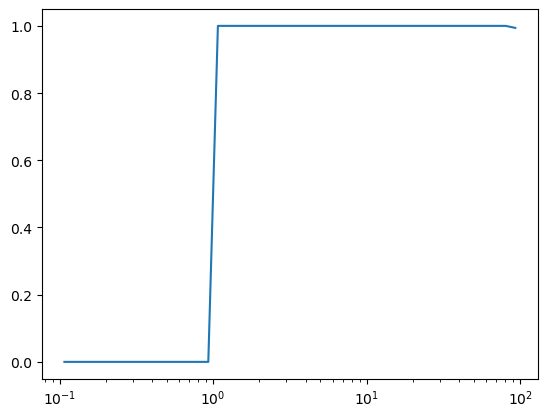

In [108]:
plt.semilogx(e_true,np.sum(pacc2.psf_kernel_map.data * dataset.mask.data, axis=(1,2)))

<AxesSubplot: xlabel='Energy [TeV]', ylabel='$\\mathrm{}$'>

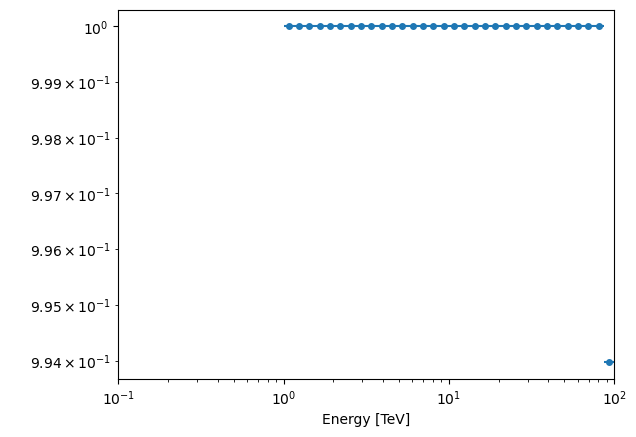

In [109]:
dataset.mask.convolve(pacc1).get_spectrum(region).plot()

In [117]:
res2, tot2 = test2.compute_npred()
res1, tot1 = test.compute_npred()
print(f"Map: {tot1:.2f} total counts")
print(f"Spec: {tot2:.2f} total counts")

Map: 150.44 total counts
Spec: 150.44 total counts


In [118]:
### Compare to the MapDataset total counts
np.sum(dataset.npred_signal().data*dataset.mask.data)

149.13902047951555

0.9999936 0.9999956


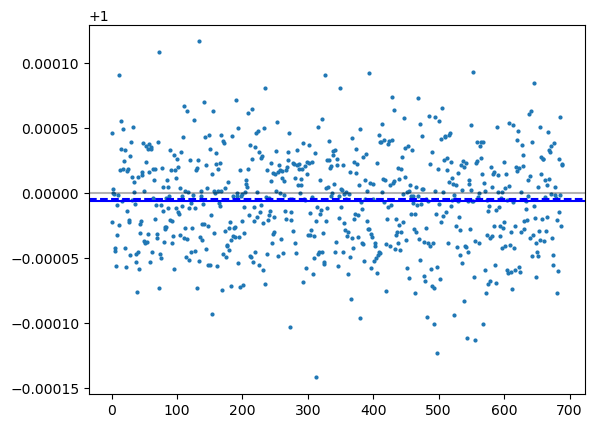

In [119]:
ratio_res = res2[list(idx_match.keys())]/res1[list(idx_match.values())]
plt.scatter(list(idx_match.keys()), ratio_res, s=4)
plt.axhline(1, c='k', alpha=0.3)
plt.axhline(np.mean(ratio_res), c='b')
plt.axhline(np.median(ratio_res), c='b', ls='--')
print(np.mean(ratio_res), np.median(ratio_res))

Text(0, 0.5, 'ratio')

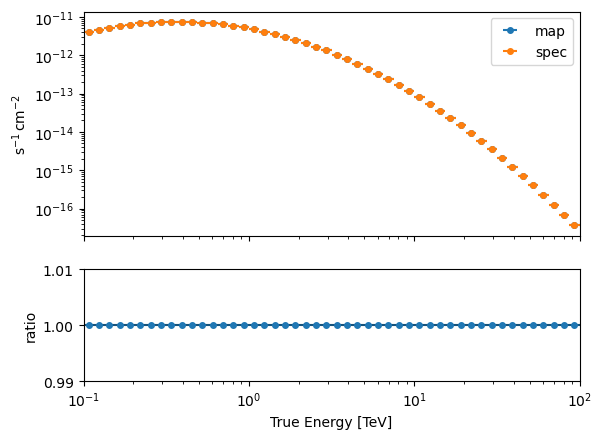

In [41]:
npred2 = SkyModel(spectral_model = test2.model.spectral_model).integrate_geom(test2.geom, test2.gti) 
npred1 = test.model.integrate_geom(test.geom, test.gti).get_spectrum(region) 

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, height_ratios=(2,1))
npred1.plot(ax=ax1, label='map')
npred2.plot(ax=ax1, label='spec')
ax1.legend()
ax1.set_xlabel(None)

ratio = npred2/npred1
ratio.plot(ax=ax2)
ax2.set_yscale('linear')
ax2.set_ylim(0.99, 1.01)
ax2.axhline(1, c='k', alpha=0.3)
ax2.set_ylabel('ratio')

/home/hpc/caph/mppi086h/wecap/software/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/astropy/units/quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


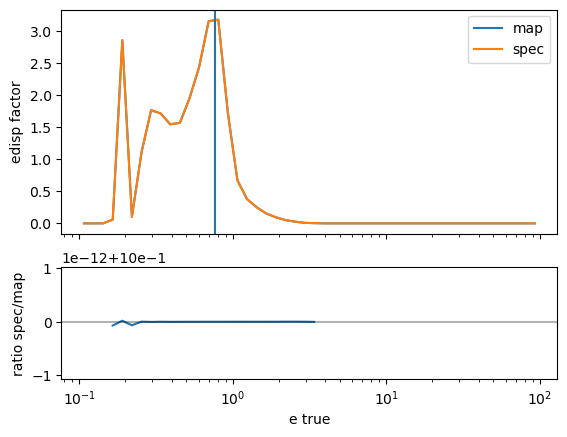

In [52]:
id2 = 7
event = test2.events.select_row_subset(test2.event_mask).select_row_subset([id2])

edisp1 = make_edisp_factors(dataset.edisp, test.geom, event)
edisp2 = make_edisp_factors(dataset.edisp, test2.geom, event)
edisp1=edisp1[0,:,5,5]
edisp2=edisp2[0,:,0,0]

e_true = test.geom.axes[0].center

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, height_ratios=(2,1))
ax1.semilogx(e_true, edisp1, label='map')
ax1.semilogx(e_true, edisp2, label='spec')
ax1.legend()
ax1.set_ylabel('edisp factor')

ax1.axvline(event.energy.to_value(e_true.unit))

ax2.plot(e_true, edisp2/edisp1)
ax2.set_ylabel('ratio spec/map')
ax2.set_xlabel('e true')
ax2.axhline(1, c='k', alpha=0.3)

(0.9, 1.1)

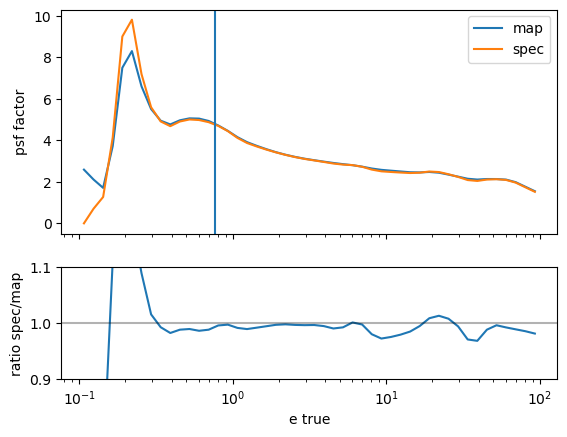

In [58]:
id2 = 7
event = test2.events.select_row_subset(test2.event_mask).select_row_subset([id2])

psf1 = make_psf_factors(dataset.psf, test.geom, event, factor=4)
psf2 = make_psf_factors(dataset.psf, test2.geom, event, factor=1)
psf1=psf1[0,:,5,5]
psf2=psf2[0,:,0,0]

e_true = test.geom.axes[0].center

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, height_ratios=(2,1))
ax1.semilogx(e_true, psf1, label='map')
ax1.semilogx(e_true, psf2, label='spec')
ax1.legend()
ax1.set_ylabel('psf factor')

ax1.axvline(event.energy.to_value(e_true.unit))

ax2.plot(e_true, psf2/psf1)
ax2.set_ylabel('ratio spec/map')
ax2.set_xlabel('e true')
ax2.axhline(1, c='k', alpha=0.3)
ax2.set_ylim(0.9, 1.1)

In [55]:
psf2

<Quantity [] 1 / deg2>

In [35]:
test.geom.pix_to_coord((5,5,1))

(<Quantity 83.63314528 deg>,
 <Quantity 22.01507573 deg>,
 <Quantity 0.12409378 TeV>)

In [37]:
test2.geom.center_skydir.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (83.63314528, 22.01507573)>

In [39]:
model_gauss.position.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (83.63314528, 22.01507573)>

In [32]:
crab_pos.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (83.63314528, 22.01507573)>

### some profiling

In [42]:
[len(obs1.events.table)]+list(test.geom.data_shape)

[7613, 48, 20, 20]

In [46]:
t=np.ones([len(obs1.events.table)]+list(test.geom.data_shape), dtype=np.float32)
t2=np.ones([len(obs1.events.table)]+list(test.geom.data_shape), dtype=np.float64)
t3=t*t2
t3.dtype

dtype('float64')

In [13]:
try:
    import resource  # linux/macos
except ImportError:
    import psutil  # windows

import sys
from contextlib import contextmanager

def peak_memory_usage():
    """Return peak memory usage in MB"""
    if sys.platform.startswith("win"):
        p = psutil.Process()
        return p.memory_info().peak_wset / 1024 / 1024

    mem = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    factor_mb = 1 / 1024
    if sys.platform == "darwin":
        factor_mb = 1 / (1024 * 1024)
    return mem * factor_mb


In [12]:
%mprun -f test.update test.update(obs1.events,dataset.exposure,dataset.psf,dataset.edisp, dataset.mask_safe)

In [23]:
%mprun -f test._compute_npred test._compute_npred()

In [33]:
mem1=peak_memory_usage()
foo()
mem2=peak_memory_usage()
print(mem2 - mem1)

0.0


In [11]:
%load_ext memory_profiler

In [30]:
from mem_test import *



In [37]:
%mprun -f foo foo()

In [70]:
# %timeit test.compute_npred()

35.5 µs ± 50 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [110]:
events = obs1.events.select_row_subset(test.event_mask)
np_sig = dataset.npred_signal()
total_ds = np_sig.data[dataset.mask_safe].sum()

np_sig.data = (np_sig.data / np_sig.geom.bin_volume()).to_value(test.irf_unit)
response_ds = np_sig.interp_by_coord(coords= events.map_coord(np_sig.geom))


print(f"Sum unbinned:   {total:.4f}\n\
Sum binned  :   {total_ds:.4f}\n\
ratio       :   {total/total_ds-1:.2%}")

Sum unbinned:   150.2607
Sum binned  :   149.1064
ratio       :   0.77%


In [111]:
offset = events.radec.separation(model_gauss.position)
bias = (response-response_ds)/response_ds
mean = bias.mean()
std = bias.std()
print(f"bias mean,std: {mean:.2%} , {std:.2%}")

bias mean,std: 0.23% , 5.49%


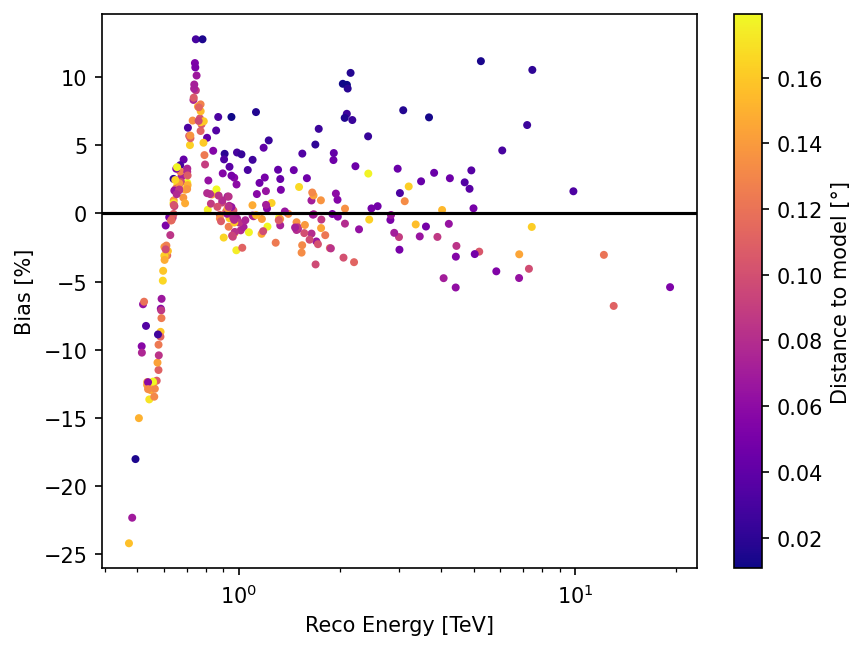

In [112]:
fig, ax1 = plt.subplots(dpi=150)
s1=ax1.scatter(events.energy, bias*100, c=offset.to_value('deg'), cmap='plasma', s=8)
cbar = plt.colorbar(s1)
cbar.set_label( 'Distance to model [°]')
ax1.semilogx()
ax1.set_ylabel('Bias [%]')
ax1.set_xlabel('Reco Energy [TeV]')
ax1.axhline(0, color='k')

# ax2.plot(offset.to_value('deg'), bias*100, '.')
# # ax1.set_ylabel('Bias [%]')
# ax2.set_xlabel('Distance to Model [deg]')

# ax2.axhline(0, color='k')

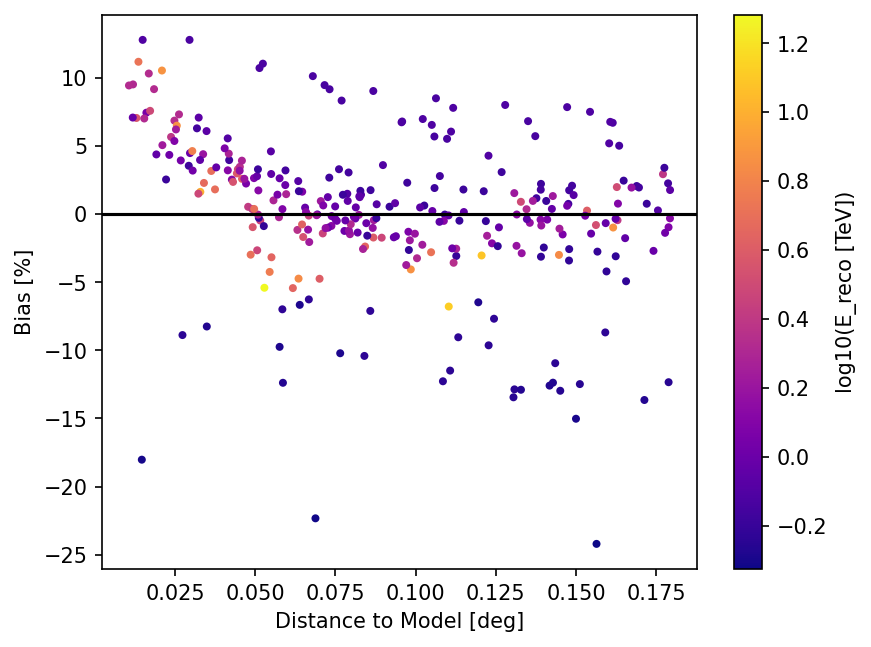

In [113]:
fig, ax1 = plt.subplots(dpi=150)
s1=ax1.scatter(offset.to_value('deg'), bias*100, c=np.log10(events.energy.to_value('TeV')), cmap='plasma', s=8)
cbar = plt.colorbar(s1)
cbar.set_label( 'log10(E_reco [TeV])')
ax1.set_ylabel('Bias [%]')
ax1.set_xlabel('Distance to Model [deg]')
ax1.axhline(0, color='k')

# ax2.plot(offset.to_value('deg'), bias*100, '.')
# # ax1.set_ylabel('Bias [%]')
# ax2.set_xlabel('Distance to Model [deg]')

# ax2.axhline(0, color='k')

Text(0, 0.5, 'response [1/TeV/sr]')

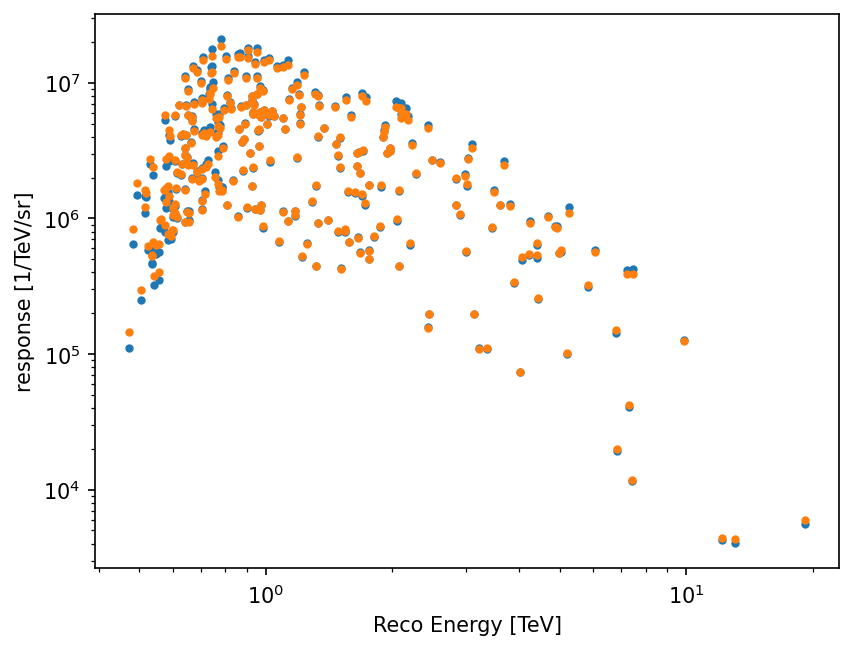

In [114]:
plt.figure(dpi=150)
plt.loglog(events.energy, response, '.')
plt.loglog(events.energy, response_ds, '.')
plt.xlabel('Reco Energy [TeV]')
plt.ylabel('response [1/TeV/sr]')

Text(0, 0.5, 'response binned')

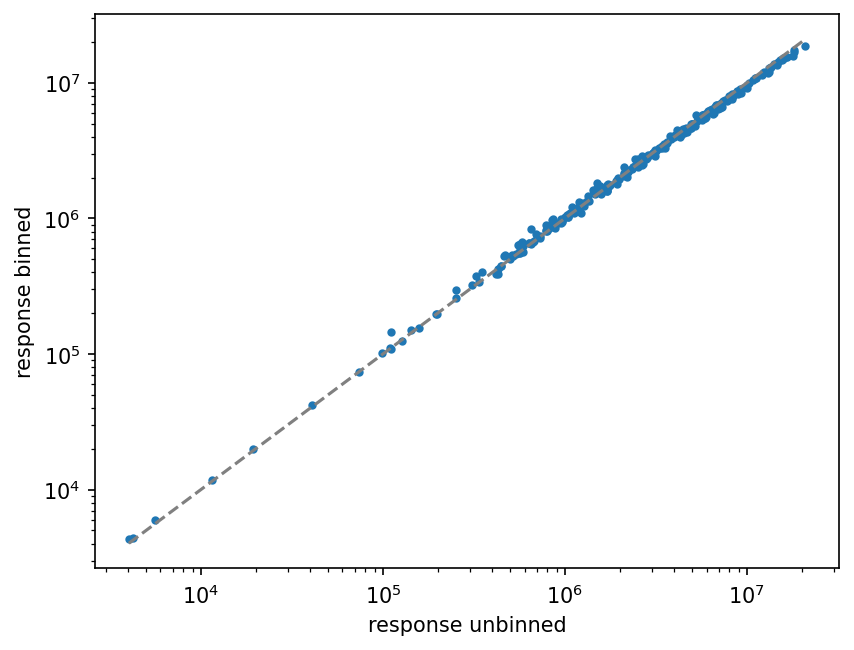

In [115]:
plt.figure(dpi=150)
plt.loglog(response, response_ds, '.')
mm=[response.min(),response.max()]
plt.plot(mm,mm, ls='--', color='gray')
plt.xlabel('response unbinned')
plt.ylabel('response binned')

In [39]:
# ef=make_edisp_factors(dataset.edisp, test.geom, obs1.events.select_row_subset(test.event_mask), position=model_gauss.position)
# pf=make_psf_factors(dataset.psf, test.geom, obs1.events.select_row_subset(test.event_mask), position=model_gauss.position)

# irf_cube = pf * ef[:,:,None,None]
# irf_cube.shape

In [40]:
test.needs_update

True

In [41]:
test.update(obs1.events,dataset.exposure,dataset.psf,dataset.edisp, dataset.mask_safe)

In [42]:
test.needs_update

False

In [48]:
test.model.spatial_model.lon_0.value -= 0.11

In [49]:
test.needs_update

True

In [50]:
test.event_mask.shape, test.event_mask.sum()

((7613,), 295)

In [36]:
print(test.irf_position_changed)

False


In [34]:
print(test.exposure is None)

False


In [53]:
obs1.events

In [54]:
test.events

In [70]:
dataset.psf.psf_map.geom.axes['rad'].edges.max()

<Quantity 0.66 deg>

## Conclusion
### float64 vs float32
The calculations should use either f64 or f32 since a combination does not really give more precision nor does it increase the speed compared to full f64 calculations.  
Doing some multiplications on f64*f64 and converting the result to f32 afterwards can be done. This gives more precision in the result at the cost of only little time, especially if those calculations only need to be performed once.  
For now we store the exposure, acceptance and the irf_cube as float32 and convert the integrated model map also to float32 before all the other multiplications. The relative differences to full f64 calculations in the final response are < 2e-07 (very acceptable in my opinion)

**map vs spec**

The edisp factors come out very similar. The psf factors on the other hand varies dependent on the oversampling factor used. For the region geometry there is no point in using a oversampling factor as the PSF is just evaluated at the rad value corresponding to the event and the model position. For larger pixels however it might be important to oversample the map in order to properly integrate the PSF within the pixels. This will increase the accuracy also for pointsources if the model position is not identical to one pixel centre. But in the case where the two positions are identical one looses accuracy. 


For the event wise response the result agrees within 0.1% when useing the same position and oversampling factor of 1

The issue with the PSF was the extrapolation combined with the normalization. Setting fill_value to 0 keeps the effect of renormalization for large maps close to 0.